In [1]:
# from google.colab import drive
# drive.mount("/content/gdrive")
# %cd "/content/gdrive/Shareddrives/CV/FinalCV"

In [1]:
%pip install imutils
%pip install pyclipper
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream
from imutils import face_utils
from Detect_Acne import *
import math

import time

import glob
import os
# print(glob.glob(os.path.join("data", "t*"))) 

In [3]:
# to detect face feature
import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# 
predictor = dlib.shape_predictor(predictor_model)


## Read Files

In [4]:
def readFiles(path):
    img = cv2.imread(path)
    return img

## Convert to Gray image

In [5]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

## Show Image

In [6]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Skin Detection

In [7]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

## Get Face Landmarks

In [8]:
def get_landmarks(Gimg):

    detector = dlib.get_frontal_face_detector()
    
    StartTime = time.time() # start time
    predictor = dlib.shape_predictor(predictor_model)
    
    print(time.time() - StartTime) # end time
    
    rects = detector(Gimg, 0)
    face = rects[0]
    
    shape = predictor(Gimg, face)
    shape = face_utils.shape_to_np(shape)

    
    landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, face).parts()])
    for points in predictor(Gimg, face).parts():
        cv2.circle(Gimg, (points.x, points.y), 1, (0, 0, 255), 10)

    
    return face, landmarks


## Get forehead based on landmarks

In [9]:

def getForeHead(landsmark):
    forehead = np.zeros([5,2], dtype = np.int)
    int_lmrks = np.array(landsmark, dtype=np.int)
    D_nose = abs(int_lmrks[27]-int_lmrks[30])
#     print("D_nose : " + str(D_nose))
    L_eye = abs(int_lmrks[36][0] - int_lmrks[40][0])
    R_eye = abs(int_lmrks[42][0] - int_lmrks[45][0]) 
    
    leftEye = ((int_lmrks[36] + int_lmrks[39]) / 2)
    rightEye = ((int_lmrks[42] + int_lmrks[45]) / 2)
    centroidEye = ( (leftEye+rightEye) / 2)
    lineX = leftEye[0] - rightEye[0]
    lineY = leftEye[1] - rightEye[1]
    mag =  math.sqrt((lineX*lineX) + (lineY*lineY))
    
    lineX = lineX/mag
    lineY = lineY/mag
    
    VlineY = lineX
    VlineX = -lineY
    
    # diff from centroidEye to noise
    diff = (centroidEye - int_lmrks[30])
    length = math.sqrt((diff[0]*diff[0]+diff[1]*diff[1]))
    
    # diff from centroidEye to leftEye
    diffL = (centroidEye - int_lmrks[16])
#     print("diffL" + str(diffL))
    lengthL = math.sqrt((diffL[0]*diffL[0]+diffL[1]*diffL[1]))

    # diff from centroidEye to rightEye
    diffR = (centroidEye - int_lmrks[0])
#     print("diffR" + str(diffR))
    lengthR = math.sqrt((diffR[0]*diffR[0]+diffR[1]*diffR[1]))

    
    # normalize C

#     print("test")
#     print(int_lmrks[5][0])
#     print(int_lmrks[17])
#     print(int_lmrks[11])
#     print(int_lmrks[26])
#     print("test")
    C = 1
    # a 
    forehead[0] =  int_lmrks[0]

    # b
    forehead[1][0] =  round(centroidEye[0] + 2*length * VlineX + 0.8*lengthR * lineX)
    forehead[1][1] =  round(centroidEye[1] + 2*length * VlineY + 0.8*lengthR * lineY)
#     print("lengthR : " + str(lengthR))
    
    # c
    forehead[2] =  int_lmrks[16]
    
    # d
    forehead[3][0] =  round(centroidEye[0] + 2*length * VlineX - 0.8*lengthL * lineX)
    forehead[3][1] =  round(centroidEye[1] + 2*length * VlineY - 0.8*lengthL * lineY)
#     print("lengthL : " + str(lengthL))
    
    # e
    forehead[4][0] =  round(centroidEye[0] + 2.5*length * VlineX)
    forehead[4][1] =  round(centroidEye[1] + 2.5*length * VlineY)
    
    return forehead

## Test Forehead Correct

1.0841467380523682
(5, 2)
[194 136]
[212  31]
[390 134]
[369  29]
[287   4]


C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/4195111923.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  forehead = np.zeros([5,2], dtype = np.int)
C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/4195111923.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the

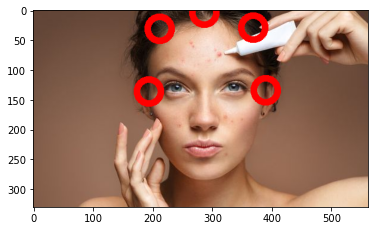

In [10]:
Origin_img = cv2.imread('pinterest/t4.jpg')
img, Gimg = img2Gray(Origin_img)
face, landmarks = get_landmarks(Gimg)
result = getForeHead(landmarks)
print(result.shape)
for points in result:
    print(points)
    cv2.circle(img, (points[0], points[1]), 20, (0, 0, 255), 10)
    
int_lmrks = np.array(landmarks, dtype=np.int)
showImage(img)

## Resturn Sking Mask

In [11]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask


## Return face mask without landsmark

In [12]:
#%pip install pyclipper
import pyclipper

def perimeter(poly):
    p = 0
    nums = poly.shape[0]
    for i in range(nums):
        p += abs(np.linalg.norm(poly[i % nums] - poly[(i + 1) % nums]))
    return p

def proportional_zoom_contour(contour, ratio):

    poly = contour[:, :]
    area_poly = abs(pyclipper.Area(poly))
    perimeter_poly = perimeter(poly)
    poly_s = []
    pco = pyclipper.PyclipperOffset()
    pco.MiterLimit = 10
    if perimeter_poly:
        d = area_poly * (1 - ratio * ratio) / perimeter_poly
        pco.AddPath(poly, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
        poly_s = pco.Execute(-d)
    poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)

    return poly_s

def get_image_hull_mask(img, image_landmarks, ie_polys=None):
    # get the mask of the image
#     if image_landmarks.shape[0] != 68:
#         raise Exception(
#             'get_image_hull_mask works only with 68 landmarks')



    
    
    int_lmrks = np.array(image_landmarks, dtype=np.int)
    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.zeros_like(img)

    
    forehead = getForeHead(image_landmarks)
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(forehead), (255,255,255))
    
    
    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))
#     cv2.fillConvexPoly(hull_mask, cv2.convexHull(
#                         int_lmrks[68:81]), (255,255, 255))

    nose = proportional_zoom_contour(int_lmrks[27:36], 1.2)
    l_eyes = proportional_zoom_contour(int_lmrks[36:42], 1.8)
    r_eyes = proportional_zoom_contour(int_lmrks[42:48], 1.8)
    mouse = proportional_zoom_contour(int_lmrks[48:60], 1.3)
    
    l_brow = proportional_zoom_contour(int_lmrks[17:22], 1.4)
    r_brow = proportional_zoom_contour(int_lmrks[22:27], 1.4)
    
    
    #face
    for i in range(17-3):
        cv2.fillConvexPoly(
            hull_mask, int_lmrks[i:i+3], (0,0, 0))
        
    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(nose), (0,0, 0))
    # left eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_eyes), (0,0, 0))
    # right eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_eyes), (0,0, 0))
    # mouse 
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(mouse), (0,0, 0))
    
    #brow
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_brow), (0,0, 0))
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_brow), (0,0, 0))
    

    

    return hull_mask

## Main 
## Step one cutting face
## Step two Acne Detectin
## Step three inplain by cv2

1.1804802417755127


C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/8439371.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)
C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/4195111923.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

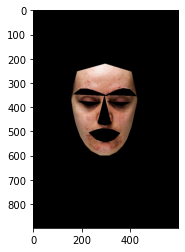

C:\Users\caichengen\Downloads\Team12\code\Detect_Acne.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)


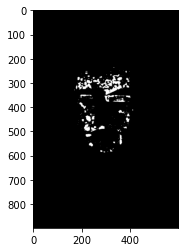

In [13]:
if __name__ == "__main__":
    
    #Read Image
    Origin_img = cv2.imread('pinterest/t3.jpg')
    Origin_img = imutils.resize(Origin_img, width=600)
    img = Origin_img.copy()
    
    img,Gimg = img2Gray(img)
    
#     # Method 1 to get face (Skin Detection and Face Detection(Harr))
#     skinMask = GetSkinMask(img)
#     faceMask = GetFaceMask(img)
#     # combine two mask
#     Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
#     img = cv2.bitwise_and(Face_Skin_Mask, img)
#     # can't cut out only face in result

    # Method 2 to get face (Use Dlib)
#     SkinMask = GetSkinMask(img)
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    cv2.imwrite("faceMask.jpg", img)
    showImage(img)
#     img = cv2.bitwise_and(SkinMask, img)
    # not a good method, which cost 1.55 sec

    
#     img = cv2.imread('./data/acne.jpg')
    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    ad.mask = cv2.cvtColor(ad.mask, cv2.COLOR_BGR2GRAY)
    ad.mask = cv2.bitwise_not(ad.mask)
    img = cv2.inpaint(Origin_img, ad.mask, 3, cv2.INPAINT_TELEA)
    showImage(ad.mask)
    cv2.imwrite("Result_First.jpg", img)
    cv2.imwrite("Mask2.jpg", ad.mask)
    

## Util function

In [15]:
def crop_image(img, d=64):
    h = img.shape[0] % d
    v = img.shape[1] % d
    img_cropped = img[h//2: img.shape[0] - (h - h//2), v//2:img.shape[1]-(v - v//2)]
    return img_cropped

def imshow(images):
    for i in range(len(images)):
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(np.transpose(images[i].numpy(), (1, 2, 0)), cv2.COLOR_BGR2RGB))
        plt.axis('off')

## DIP Model_1

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from PIL import Image



class DeepImagePrior(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_conv_1 = nn.Conv2d(3, 8, 5, stride=2, padding=2)
        self.down_bn_1 = nn.BatchNorm2d(8)
        self.down_conv_1_2 = nn.Conv2d(8, 8, 5, stride=2, padding=2)
        
        self.down_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.down_bn_2 = nn.BatchNorm2d(16)
        self.down_conv_2_2 = nn.Conv2d(16, 16, 5, stride=2, padding=2)


        self.down_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.down_bn_3 = nn.BatchNorm2d(32)
        self.down_conv_3_2 = nn.Conv2d(32, 32, 5, stride=2, padding=2)
        self.skip_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.down_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.down_bn_4 = nn.BatchNorm2d(64)
        self.down_conv_4_2 = nn.Conv2d(64, 64, 5, stride=2, padding=2)
        self.skip_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)
        
        self.down_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.down_bn_5 = nn.BatchNorm2d(128)
        self.down_conv_5_2 = nn.Conv2d(128, 128, 5, stride=2, padding=2)
        self.skip_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.down_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.down_bn_6 = nn.BatchNorm2d(256)
        self.down_conv_6_2 = nn.Conv2d(256, 256, 5, stride=2, padding=2)

        self.up_deconv_5 = nn.ConvTranspose2d(256, (128-4), 4, stride=2, padding=1)
        self.up_bn_5 = nn.BatchNorm2d(128)
        self.up_deconv_5_2 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)

        self.up_deconv_4 = nn.ConvTranspose2d(128, (64-4), 4, stride=2, padding=1)
        self.up_bn_4 = nn.BatchNorm2d(64)
        self.up_deconv_4_2 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)

        self.up_deconv_3 = nn.ConvTranspose2d(64, (32-4), 4, stride=2, padding=1)
        self.up_bn_3 = nn.BatchNorm2d(32)
        self.up_deconv_3_2 = nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1)

        self.up_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.up_bn_2 = nn.BatchNorm2d(16)
        self.up_deconv_2_2 = nn.ConvTranspose2d(16, 16, 4, stride=2, padding=1)

        self.up_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.up_bn_1 = nn.BatchNorm2d(8)
        self.up_deconv_1_2 = nn.ConvTranspose2d(8, 8, 4, stride=2, padding=1)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

        self.drop = nn.Dropout(0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)


    def forward(self, noise):
        
        down_1 = self.down_conv_1(noise)
        down_1 = self.down_bn_1(down_1)
        down_1 = self.drop(down_1)
        down_1 = F.leaky_relu(down_1)
        down_1 = self.down_conv_1_2(down_1)
        down_1 = self.down_bn_1(down_1)
        down_1 = F.leaky_relu(down_1)
        
        down_2 = self.down_conv_2(down_1)
        down_2 = self.down_bn_2(down_2)
        down_2 = self.drop(down_2)
        down_2 = F.leaky_relu(down_2)
        down_2 = self.down_conv_2_2(down_2)
        down_2 = self.down_bn_2(down_2)
        down_2 = F.leaky_relu(down_2)
        
        down_3 = self.down_conv_3(down_2)
        down_3 = self.down_bn_3(down_3)
        down_3 = self.drop(down_3)
        down_3 = F.leaky_relu(down_3)
        down_3 = self.down_conv_3_2(down_3)
        down_3 = self.down_bn_3(down_3)
        down_3 = F.leaky_relu(down_3)
        skip_3 = self.skip_conv_3(down_3)
        
        down_4 = self.down_conv_4(down_3)
        down_4 = self.down_bn_4(down_4)
        down_4 = self.drop(down_4)
        down_4 = F.leaky_relu(down_4)
        down_4 = self.down_conv_4_2(down_4)
        print(down_4.shape)
        down_4 = self.down_bn_4(down_4)
        down_4 = F.leaky_relu(down_4)
        skip_4 = self.skip_conv_4(down_4)
        
        down_5 = self.down_conv_5(down_4)
        down_5 = self.down_bn_5(down_5)
        down_5 = self.drop(down_5)
        down_5 = F.leaky_relu(down_5)

        skip_5 = self.skip_conv_5(down_5)
        
        down_6 = self.down_conv_6(down_5)
        down_6 = self.down_bn_6(down_6)
        down_6 = self.drop(down_6)
        down_6 = F.leaky_relu(down_6)

        
        up_5 = self.up_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5],1)
        up_5 = self.up_bn_5(up_5)
        up_5 = F.leaky_relu(up_5)
    
        up_4 = self.up_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4],1)
        up_4 = self.up_bn_4(up_4)
        up_4 = F.leaky_relu(up_4)
        
        up_3 = self.up_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3],1)
        up_3 = self.up_bn_3(up_3)
        up_3 = F.leaky_relu(up_3)
        
        up_2 = self.up_deconv_2(up_3)
        up_2 = self.up_bn_2(up_2)
        up_2 = F.leaky_relu(up_2)
        
        up_1 = self.up_deconv_1(up_2)
        up_1 = self.up_bn_1(up_1)
        up_1 = F.leaky_relu(up_1)
        
        output = self.out_deconv(up_1)
        output = self.out_bn(output)
        output = torch.sigmoid(output)
        
        return output
        
        

## DIP Model 2

In [17]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from PIL import Image


class DeepImagePrior(nn.Module):
    def __init__(self):
        super().__init__()


        # Down
        self.down_conv_1_1 = nn.Conv2d(3, 16, kernel_size=3,padding=1)
        self.down_bn_1_1 = nn.InstanceNorm2d(16)
        self.relu1_1 = nn.SiLU()
        self.down_conv_1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.down_bn_1_2 = nn.InstanceNorm2d(16)
        self.relu1_2 = nn.SiLU()
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)

        self.down_conv_2_1 = nn.Conv2d(16, 32, kernel_size=3,padding=1)
        self.down_bn_2_1 = nn.InstanceNorm2d(32)
        self.relu2_1 = nn.SiLU()
        self.down_conv_2_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.down_bn_2_2 = nn.InstanceNorm2d(32)
        self.relu2_2 = nn.SiLU()
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2)

        self.down_conv_3_1 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.down_bn_3_1 = nn.InstanceNorm2d(64)
        self.relu3_1 = nn.SiLU()
        self.down_conv_3_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.down_bn_3_2 = nn.InstanceNorm2d(64)
        self.relu3_2 = nn.SiLU()
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2)

        self.down_conv_4_1 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.down_bn_4_1 = nn.InstanceNorm2d(128)
        self.relu4_1 = nn.SiLU()
        self.down_conv_4_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.down_bn_4_2 = nn.InstanceNorm2d(128)
        self.relu4_2 = nn.SiLU()
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2)

        self.down_conv_5_1 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.down_bn_5_1 = nn.InstanceNorm2d(128)
        self.relu5_1 = nn.SiLU()
        self.down_conv_5_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.down_bn_5_2 = nn.InstanceNorm2d(128)
        self.relu5_2 = nn.SiLU()
        self.max_pool_5 = nn.MaxPool2d(kernel_size=2)
        

        # UP
        self.unsample_4 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_deconv_4_1 = nn.ConvTranspose2d(256, 64, kernel_size=3, padding=1)
        self.up_bn_4_1 = nn.InstanceNorm2d(64)
        self.Up_relu4_1 = nn.SiLU()
        self.up_deconv_4_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up_bn_4_2 = nn.InstanceNorm2d(64)
        self.Up_relu4_2 = nn.SiLU()

        self.unsample_3 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_deconv_3_1 = nn.ConvTranspose2d(128, 32, kernel_size=3, padding=1)
        self.up_bn_3_1 = nn.InstanceNorm2d(32)
        self.Up_relu3_1 = nn.SiLU()
        self.up_deconv_3_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.up_bn_3_2 = nn.InstanceNorm2d(32)
        self.Up_relu3_2 = nn.SiLU()

        self.unsample_2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_deconv_2_1 = nn.ConvTranspose2d(64, 16, kernel_size=3,  padding=1)
        self.up_bn_2_1 = nn.InstanceNorm2d(16)
        self.Up_relu2_1 = nn.SiLU()
        self.up_deconv_2_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.up_bn_2_2 = nn.InstanceNorm2d(16)
        self.Up_relu2_2 = nn.SiLU()

        self.unsample_1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up_deconv_1_1 = nn.ConvTranspose2d(32, 8, kernel_size=3, padding=1)
        self.up_bn_1_1 = nn.InstanceNorm2d(8)
        self.Up_relu1_1 = nn.SiLU()
        self.up_deconv_1_2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.up_bn_1_2 = nn.InstanceNorm2d(8)
        self.Up_relu1_2 = nn.SiLU()

        self.out_deconv = nn.Conv2d(8, 3, kernel_size=1)
        self.out_bn = nn.InstanceNorm2d(3)

        self.drop = nn.Dropout(0.05)
        self.maxpool = nn.MaxPool2d(kernel_size=2)


    def forward(self, noise):
        
        down_1 = self.down_conv_1_1(noise)
        down_1 = self.down_bn_1_1(down_1)
        down_1 = self.drop(down_1)
        down_1 = self.relu1_1(down_1)
        down_1 = self.down_conv_1_2(down_1)
        down_1 = self.down_bn_1_2(down_1)
        skip_1 = self.relu1_2(down_1)
        down_1 = self.max_pool_1(skip_1)
        
        down_2 = self.down_conv_2_1(down_1)
        down_2 = self.down_bn_2_1(down_2)
        down_2 = self.drop(down_2)
        down_2 = self.relu2_1(down_2)
        down_2 = self.down_conv_2_2(down_2)
        down_2 = self.down_bn_2_2(down_2)
        skip_2 = self.relu2_2(down_2)
        down_2 = self.max_pool_2(skip_2)
        
        down_3 = self.down_conv_3_1(down_2)
        down_3 = self.down_bn_3_1(down_3)
        down_3 = self.drop(down_3)
        down_3 = self.relu3_1(down_3)
        down_3 = self.down_conv_3_2(down_3)
        down_3 = self.down_bn_3_2(down_3)
        skip_3 = self.relu3_2(down_3)
        down_3 = self.max_pool_3(skip_3)
        
        down_4 = self.down_conv_4_1(down_3)
        down_4 = self.down_bn_4_1(down_4)
        down_4 = self.drop(down_4)
        down_4 = self.relu4_1(down_4)
        down_4 = self.down_conv_4_2(down_4)
        down_4 = self.down_bn_4_2(down_4)
        skip_4 = self.relu4_2(down_4)
        down_4 = self.max_pool_4(skip_4)

        down_5 = self.down_conv_5_1(down_4)
        down_5 = self.down_bn_5_1(down_5)
        down_5 = self.drop(down_5)
        down_5 = self.relu5_1(down_5)
        down_5 = self.down_conv_5_2(down_5)
        down_5 = self.down_bn_5_2(down_5)
        skip_5 = self.relu5_2(down_5)
        down_5 = self.max_pool_5(skip_5)
        

        up_4 = self.unsample_4(skip_5)
        up_4 = torch.cat([skip_4, up_4], dim=1)
        up_4 = self.up_deconv_4_1(up_4)
        up_4 = self.up_bn_4_1(up_4)
        up_4 = self.drop(up_4)
        up_4 = self.Up_relu4_1(up_4)
        up_4 = self.up_deconv_4_2(up_4)
        up_4 = self.up_bn_4_2(up_4)
        up_4 = self.Up_relu4_2(up_4)

        up_3 = self.unsample_3(up_4)
        up_3 = torch.cat([skip_3, up_3], dim=1)
        up_3 = self.up_deconv_3_1(up_3)
        up_3 = self.up_bn_3_1(up_3)
        up_3 = self.drop(up_3)
        up_3 = self.Up_relu3_1(up_3)
        up_3 = self.up_deconv_3_2(up_3)
        up_3 = self.up_bn_3_2(up_3)
        up_3 = self.Up_relu3_2(up_3)

        up_2 = self.unsample_2(up_3)
        up_2 = torch.cat([skip_2, up_2], dim=1)
        up_2 = self.up_deconv_2_1(up_2)
        up_2 = self.up_bn_2_1(up_2)
        up_2 = self.drop(up_2)
        up_2 = self.Up_relu2_1(up_2)
        up_2 = self.up_deconv_2_2(up_2)
        up_2 = self.up_bn_2_2(up_2)
        up_2 = self.Up_relu2_2(up_2)
        

        up_1 = self.unsample_1(up_2)
        up_1 = torch.cat([skip_1, up_1], dim=1)
        up_1 = self.up_deconv_1_1(up_1)
        up_1 = self.up_bn_1_1(up_1)
        up_1 = self.drop(up_1)
        up_1 = self.relu1_1(up_1)
        up_1 = self.up_deconv_1_2(up_1)
        up_1 = self.up_bn_1_2(up_1)
        up_1 = self.relu1_2(up_1)
        
        output = self.out_deconv(up_1)
        output = torch.sigmoid(output)
        
        return output
        
        

## Convert ALL Image

pinterest\t1.jpg
1.0533883571624756


C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_14728/8439371.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)
C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_14728/4195111923.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

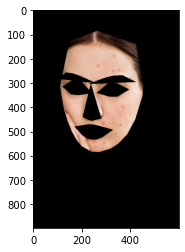

C:\Users\caichengen\Documents\GitHub\FinalCV\Submission\Detect_Acne.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)


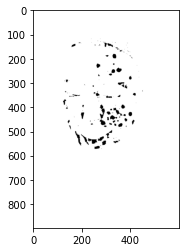

  0%|          | 0/1800 [00:00<?, ?it/s]

C:\Users\caichengen\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

In [18]:
for FILENAME in glob.glob(f'pinterest/*.jpg'):
    print(FILENAME)
    Origin_img = cv2.imread(FILENAME)
    Origin_img = imutils.resize(Origin_img, width=600)
    #mask = cv2.imread('data/kate_mask.jpg')
    #showImage(mask)

    img = Origin_img.copy()
        
    img,Gimg = img2Gray(img)
        
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    showImage(img)

    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    showImage(ad.mask)
    # Origin_img = imutils.resize(Origin_img, width=600)
    # mask = cv2.imread("Data/kate_mask.png", cv2.IMREAD_GRAYSCALE)
    # mask = cv2.cvtColor(ad.mask, cv2.COLOR_GRAY2BGR)
    InputImage = Origin_img.copy()
    # cut image, transform float type, Convert dimension [W x H x C] => [C x W x H]
    Input = torch.from_numpy(crop_image(crop_image(InputImage/255).astype(float),16).transpose(2,0,1))
    Input_mask = torch.from_numpy(crop_image((ad.mask/255).astype(float)).transpose(2,0,1)).unsqueeze(0)

    white_mask = torch.from_numpy(np.ones_like(Input_mask)).cuda()

    GenerateRandomInput = torch.Generator()
    GenerateRandomInput.manual_seed(305)
    RandomInput = torch.FloatTensor(Input.shape).uniform_(0, 1, generator=GenerateRandomInput)

    # model = Unet(p=0.05).cuda() #
    model = DeepImagePrior().cuda()
    criterion = nn.MSELoss()
    lr = 1e-2
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    def train(epochs, model, Input, Input_mask, RandomInput, optimizer, iter, verbose = True):
        global white_mask
        
        images = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            Input = Input.cuda()
            Input_mask = Input_mask.cuda()
            out_image = model(RandomInput[None, ...].cuda())
            # print(Input.shape)
            loss = criterion((out_image * Input_mask[None,...]), (Input[None,...] * Input_mask[None,...]))
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch%iter == 0:
                if (verbose):
                    print(loss.data.cpu())
                model.eval()
                predict = out_image
                images.append(predict.detach().cpu().reshape(Input.shape))


        return predict, images


    kate_impainting, kate_images = train(1800, model, Input, Input_mask, RandomInput, opt, 1800)

    for i in range(len(kate_images)):
        imshow([kate_images[i].detach().cpu().reshape(Input.shape)])
        
    img_for_save = np.transpose(kate_images[-1].detach().cpu().reshape(Input.shape).numpy(), (1, 2, 0))*255
    cv2.imwrite(f'./result_{FILENAME}', np.uint8(img_for_save))
    
    print(f'image saved in ./result_{FILENAME}')

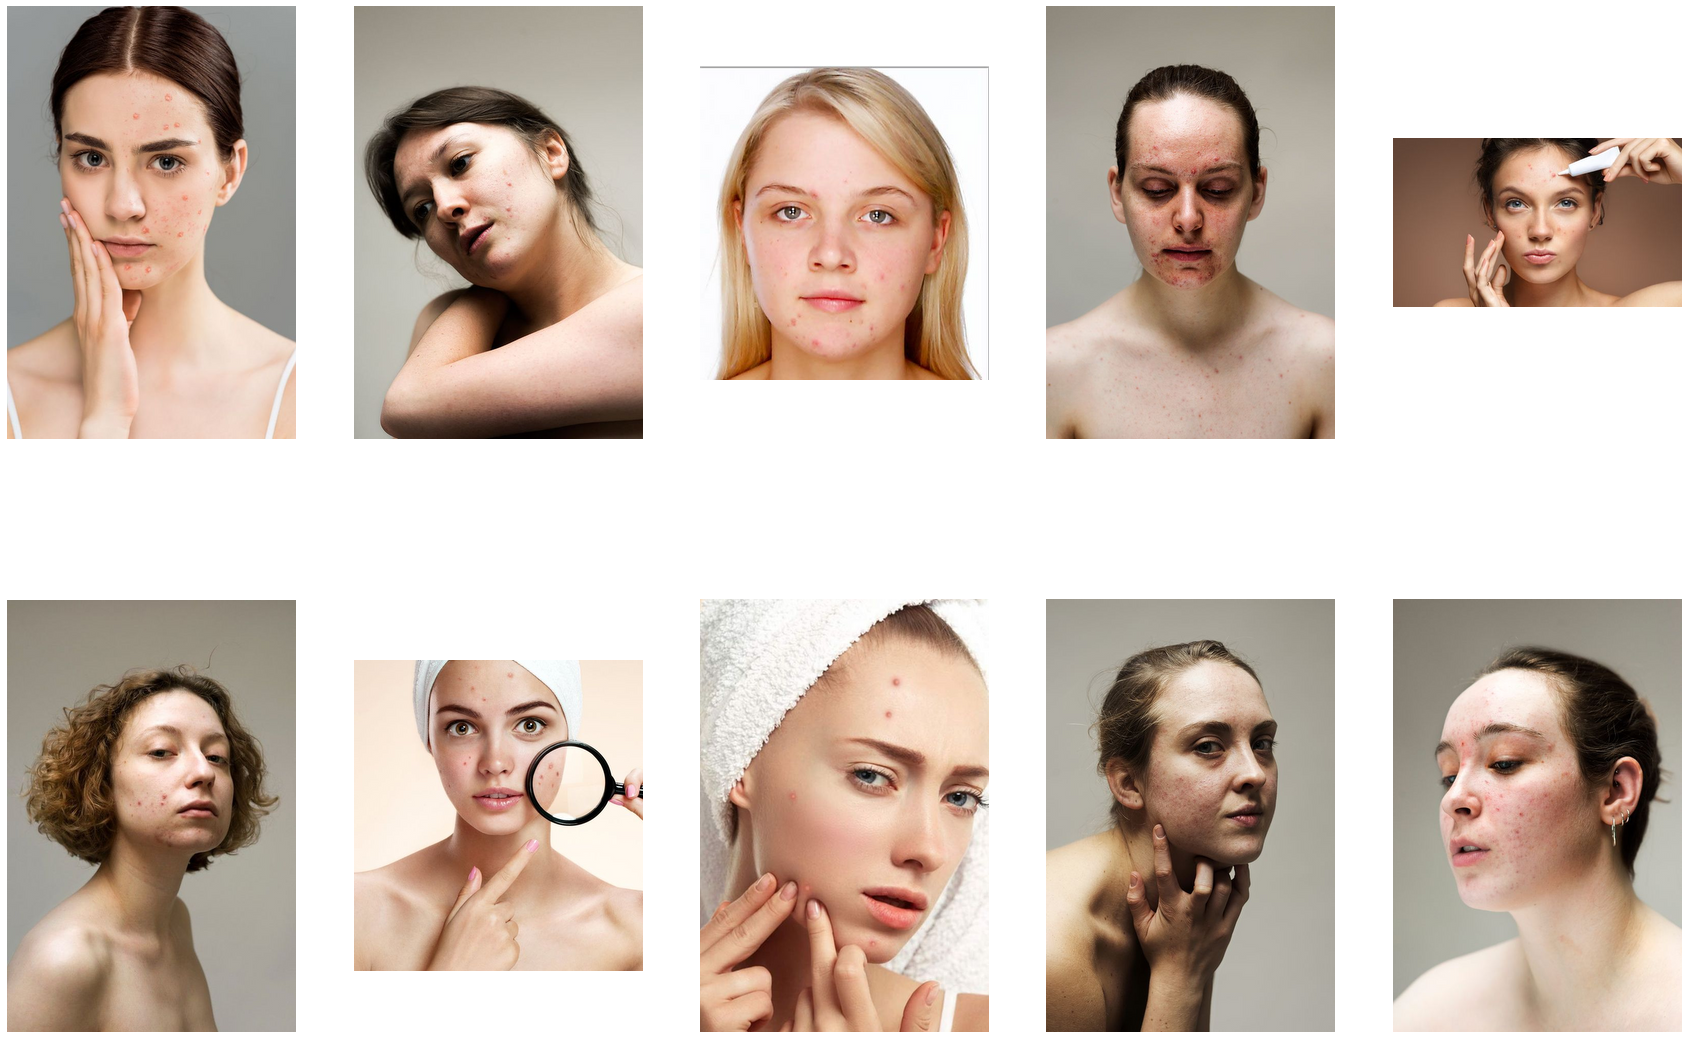

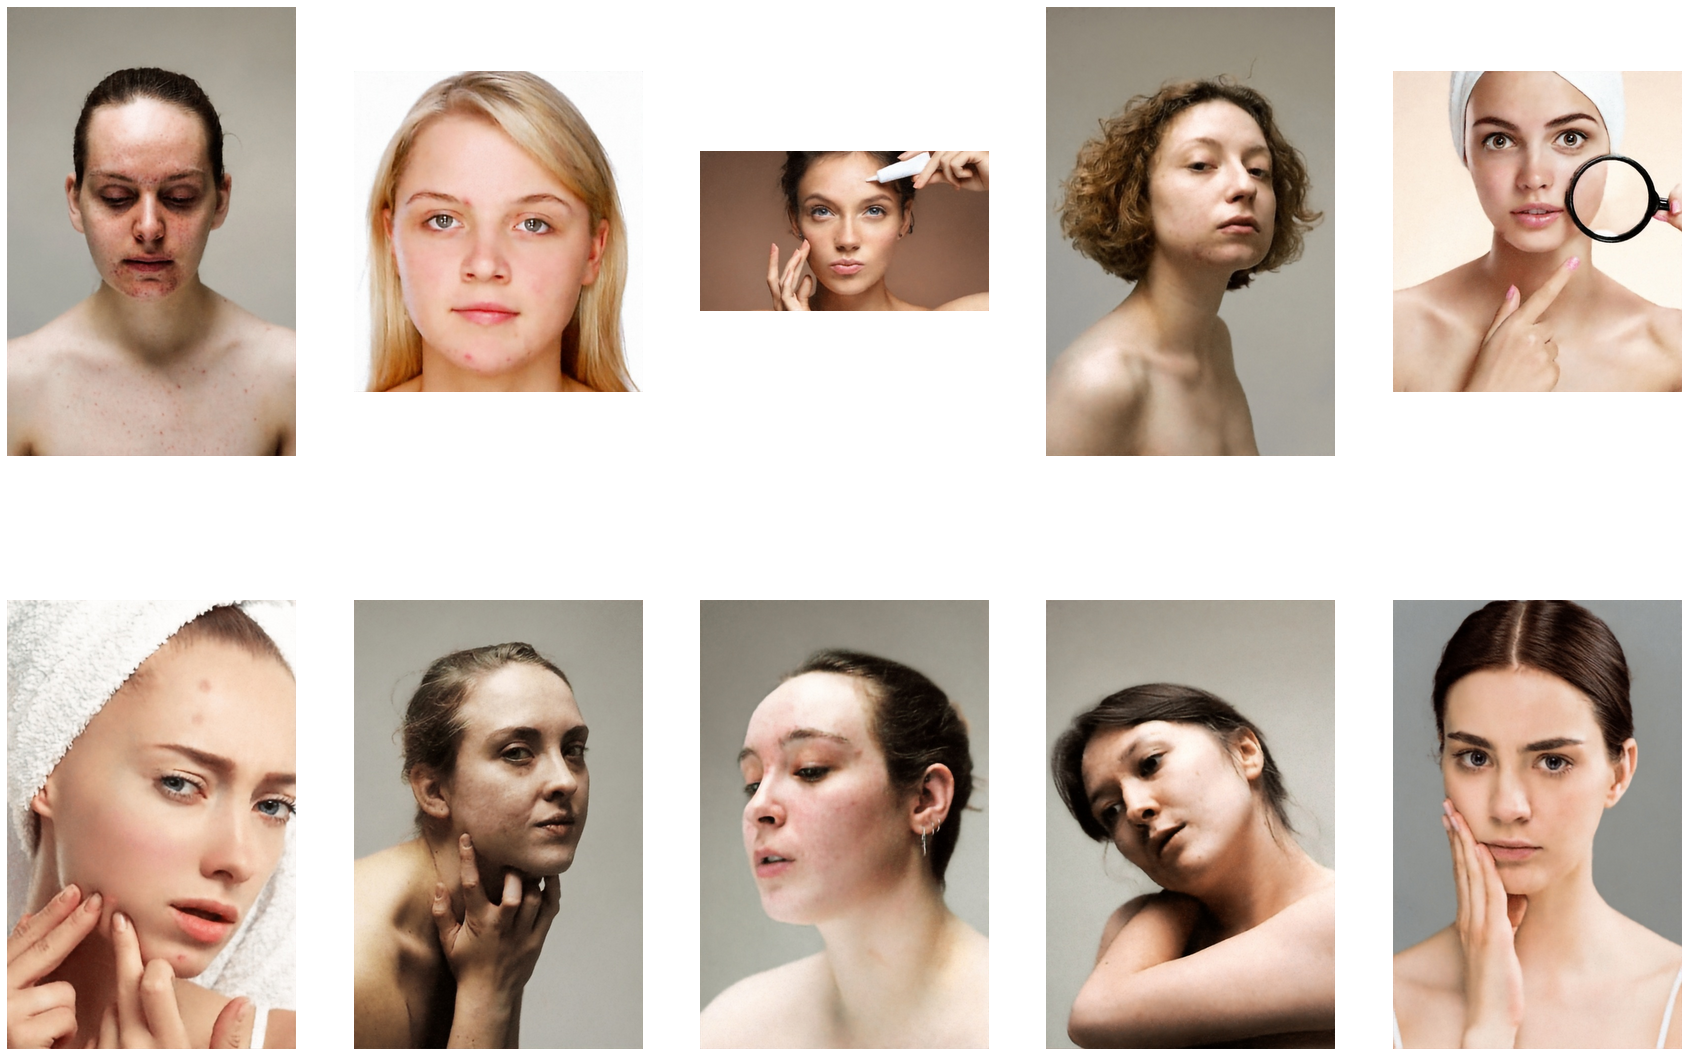

In [19]:
import math
def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), f"images should have 1 or 3 channels, but got {n_channels}"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    plt.figure(figsize=(len(images_np) + factor, factor))
    lines = math.floor(len(images_np) / nrow)
    for ind, im in enumerate(images_np):
        plt.subplot(lines, nrow, ind+1)
        plt.axis('off')
        if images_np[0].shape[0] == 1:
            plt.imshow(im[0], cmap='gray', interpolation=interpolation)
        else:
            plt.imshow(im.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()


inputs = []
for file in glob.glob('./pinterest/*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose(2,0,1)
    inputs.append(img)
plot_image_grid(inputs, 5, 20)


inputs = []
for file in glob.glob('./result_pinterest/*'):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose(2,0,1)
    inputs.append(img)
plot_image_grid(inputs, 5, 20)

## Inplaint for one image

1.1344149112701416


C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_14728/8439371.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)
C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_14728/4195111923.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

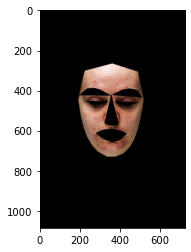

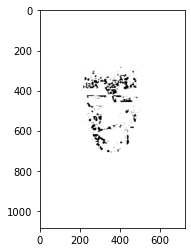

  0%|          | 0/1800 [00:00<?, ?it/s]

tensor(0.0004, dtype=torch.float64)


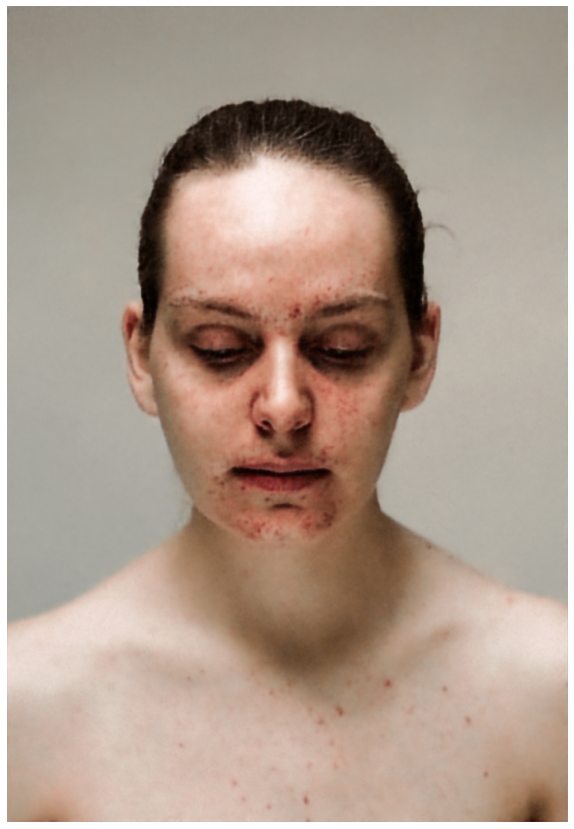

In [20]:
if __name__ == "__main__":
    FILENAME = 'pinterest/t3.jpg'
    Origin_img = cv2.imread(FILENAME)
    # Origin_img = imutils.resize(Origin_img, width=600)

    img = Origin_img.copy()
        
    img,Gimg = img2Gray(img)
        
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    showImage(img)

    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    showImage(ad.mask)
    # Origin_img = imutils.resize(Origin_img, width=600)
    # mask = cv2.imread("Data/kate_mask.png", cv2.IMREAD_GRAYSCALE)
    # mask = cv2.cvtColor(ad.mask, cv2.COLOR_GRAY2BGR)
    InputImage = Origin_img.copy()
    # cut image, transform float type, Convert dimension [W x H x C] => [C x W x H]
    Input = torch.from_numpy(crop_image(crop_image(InputImage/255).astype(float),16).transpose(2,0,1))
    Input_mask = torch.from_numpy(crop_image((ad.mask/255).astype(float)).transpose(2,0,1)).unsqueeze(0)


    white_mask = torch.from_numpy(np.ones_like(Input_mask)).cuda()

    GenerateRandomInput = torch.Generator()
    GenerateRandomInput.manual_seed(305)
    RandomInput = torch.FloatTensor(Input.shape).uniform_(0, 1, generator=GenerateRandomInput)

    # model = Unet(p=0.05).cuda() #
    model = DeepImagePrior().cuda()
    criterion = nn.MSELoss()
    lr = 1e-2
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    def train(epochs, model, Input, Input_mask, RandomInput, optimizer, iter, verbose = True):
        global white_mask
        
        images = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            Input = Input.cuda()
            Input_mask = Input_mask.cuda()
            out_image = model(RandomInput[None, ...].cuda())
            # print(Input.shape)
            loss = criterion((out_image * Input_mask[None,...]), (Input[None,...] * Input_mask[None,...]))
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch%iter == 0:
                if (verbose):
                    print(loss.data.cpu())
                model.eval()
                predict = out_image
                images.append(predict.detach().cpu().reshape(Input.shape))


        return predict, images


    _, Output_images = train(1800, model, Input, Input_mask, RandomInput, opt, 1800)

    for i in range(len(Output_images)):
        imshow([Output_images[i].detach().cpu().reshape(Input.shape)])
        
    img_for_save = np.transpose(Output_images[-1].detach().cpu().reshape(Input.shape).numpy(), (1, 2, 0))*255
    cv2.imwrite(f'./result_{FILENAME}', np.uint8(img_for_save))

## Combine Result from Original

In [21]:
## C W H -> W H C
Result_2 = np.transpose(Output_images[-1].detach().cpu().reshape(Input.shape).numpy(), (1, 2, 0))
Mask = crop_image(ad.mask)
Mask = cv2.cvtColor(Mask, cv2.COLOR_BGR2GRAY)
Mask = cv2.bitwise_not(Mask)
Result_2 = cv2.bitwise_and(Result_2, Result_2, mask = Mask)
Result_2 = Result_2.astype(np.float32)
# showImage(Result_2)

Target = crop_image(Origin_img)
Mask = cv2.bitwise_not(Mask)
Target = cv2.bitwise_and(Target, Target, mask = Mask)
Target = Target.astype(np.float32)/255

des = cv2.add(Target, Result_2)
des = des*255
cv2.imwrite("Result_2.jpg", np.uint8(des))


True

In [26]:
heightResize = 480
framesSkipping = 1

cameraObject = cv2.VideoCapture('video.mp4')
ret, image = cameraObject.read()
height = image.shape[0]

frame_resize_scale = float(height)/heightResize
modelPath = "shape_predictor_68_face_landmarks.dat"

faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(modelPath)


def Recording():
    count = 0
    # open webcam
#     vs = WebcamVideoStream().start()
    start = time.time()
#     fps = vs.stream.get(cv2.CAP_PROP_FPS)
#     print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    fourcc = cv2.VideoWriter_fourcc('F','M','P','4')
    out = cv2.VideoWriter('Result1.mp4', fourcc, 20, (int(cameraObject.get(3)),int(cameraObject.get(4))))
    while True:
        # turn to gray image to detect face
        ret, frame = cameraObject.read()
        try: 
            img = frame.copy()
    #         img = imutils.resize(img, width=600)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             print(img.shape)

            faces = faceDetector(img,0)
            for face in faces:
    #             newRectValues = dlib.rectangle(int(face.left() * frame_resize_scale),
    #                                int(face.top() * frame_resize_scale),
    #                                int(face.right() * frame_resize_scale),
    #                                int(face.bottom() * frame_resize_scale))
                predictor = shapePredictor(img, face)
                landmarks = np.matrix([[p.x, p.y] for p in predictor.parts()])
                try:
                    faceMask = get_image_hull_mask(img, landmarks)
                except:
                    pass
            img = cv2.bitwise_and(faceMask, img)
    #         cv2.imshow("Frame", img)

            ad = Acne_Dector(img)
            ad.run(method =1, debug=False)
            ad.mask = cv2.cvtColor(ad.mask, cv2.COLOR_BGR2GRAY)
            ad.mask = cv2.bitwise_not(ad.mask)
            img = cv2.inpaint(frame, ad.mask, 3, cv2.INPAINT_TELEA)
            cv2.imshow('frame', img)
            count = count + 1
            # calculate framePerSecond at an interval of 100 frames
            out.write(img)

            key = cv2.waitKey(1) & 0xff
            if key == ord('q'):
                break
        except:
            break;

    
    cv2.destroyAllWindows()
    cameraObject.release()
    out.release()
    print("done")
#     vs.stop()


Recording()

C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/8439371.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_lmrks = np.array(image_landmarks, dtype=np.int)
C:\Users\CAICHE~1\AppData\Local\Temp/ipykernel_18788/4195111923.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

done
